# **Flight Price Prediction Dataset**

## 0. Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 1. Loading The CSV Dataset

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving flight_data.csv to flight_data (8).csv


In [ ]:
df = pd.read_csv('flight_data.csv')

In [ ]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR ? DEL,22:20,01:10,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL ? LKO ? BOM ? COK,09:25,04:25,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU ? NAG ? BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR ? NAG ? DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [ ]:
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


## 2. Cleaning and Preprocessing

 ### Remove missing values in the dataset

In [ ]:
print("Missing values before imputation:")
print(df.isnull().sum())

Missing values before imputation:
Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64


In [ ]:
missing_route = df[df['Route'].isnull()]
print(missing_route)

        Airline Date_of_Journey Source Destination Route Dep_Time  \
9039  Air India       6/05/2019  Delhi      Cochin   NaN    09:45   

     Arrival_Time Duration Total_Stops Additional_Info  Price  
9039        09:25  23h 40m         NaN         No info   7480  


The two missing values are in the same row, so we will remove that row entirely.



In [ ]:
df = df.dropna()

### Remove duplicates in the dataset

In [ ]:
df.duplicated().sum()

222

In [ ]:
df = df.drop_duplicates()

### Convert flight duration to decimal numbers

In [ ]:
def duration_to_hours(duration):
    hours, minutes = 0, 0
    if 'h' in duration:
        hours = int(duration.split('h')[0])
    if 'm' in duration:
        minutes = int(duration.split(' ')[-1].replace('m', ''))
    return hours + minutes / 60


df['Duration_Hours'] = df['Duration'].apply(duration_to_hours)
df.drop(['Duration'], axis=1, inplace=True)

### Convert the hours to decimal numbers

In [ ]:
from datetime import datetime

In [ ]:
def convert_to_decimal_hour(time_str):
    """
    Convert a time string to a decimal hour.
    """
    if pd.isna(time_str):
        return None
    try:
        time_obj = datetime.strptime(time_str, "%H:%M")
    except ValueError:
        raise ValueError(f"Invalid time format: {time_str}")

    # Convert time to decimal hours
    decimal_hour = time_obj.hour + time_obj.minute / 60
    return decimal_hour


df['Dep_Hour'] = df['Dep_Time'].apply(lambda x: convert_to_decimal_hour(x))
df['Arr_Hour'] = df['Arrival_Time'].apply(lambda x: convert_to_decimal_hour(x))
df.drop(['Dep_Time', 'Arrival_Time'], axis=1, inplace=True)

### Adjust the date of the flight

In [ ]:
df['Date_of_Journey'] = pd.to_datetime(df['Date_of_Journey'], format='%d/%m/%Y', errors='coerce')
df['Journey_Day'] = df['Date_of_Journey'].dt.day
df['Journey_Month'] = df['Date_of_Journey'].dt.month
df['Journey_Weekday'] = df['Date_of_Journey'].dt.weekday
df.drop(['Date_of_Journey'], axis=1, inplace=True)

### The updated dataset

In [ ]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Duration_Hours,Dep_Hour,Arr_Hour,Journey_Day,Journey_Month,Journey_Weekday
0,IndiGo,Banglore,New Delhi,BLR ? DEL,non-stop,No info,3897,2.833333,22.333333,1.166667,24,3,6
1,Air India,Kolkata,Banglore,CCU ? IXR ? BBI ? BLR,2 stops,No info,7662,7.416667,5.833333,13.250000,1,5,2
2,Jet Airways,Delhi,Cochin,DEL ? LKO ? BOM ? COK,2 stops,No info,13882,19.000000,9.416667,4.416667,9,6,6
3,IndiGo,Kolkata,Banglore,CCU ? NAG ? BLR,1 stop,No info,6218,5.416667,18.083333,23.500000,12,5,6
4,IndiGo,Banglore,New Delhi,BLR ? NAG ? DEL,1 stop,No info,13302,4.750000,16.833333,21.583333,1,3,4


## 3. Data Analysis

### Visualization 1: Distribution of Ticket Prices

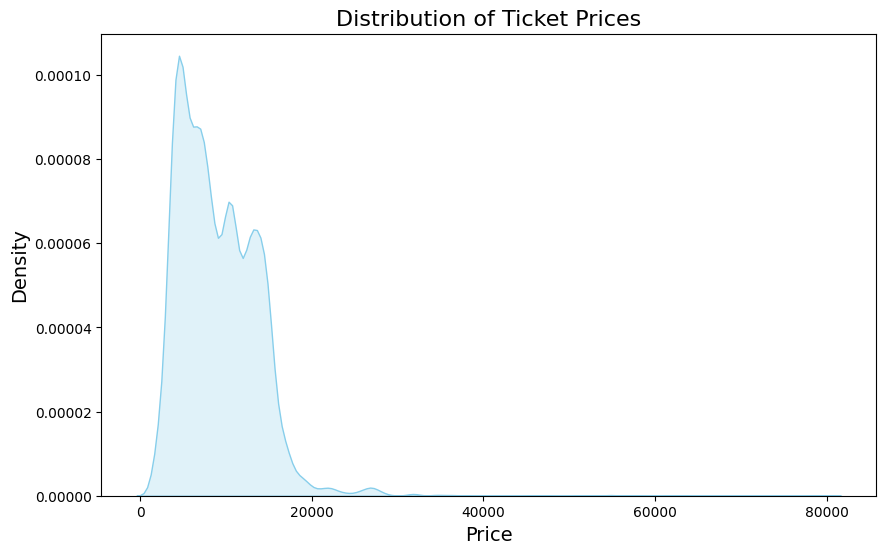

In [ ]:
plt.figure(figsize=(10, 6))
sns.kdeplot(df['Price'], color='skyblue', fill=True)
plt.title('Distribution of Ticket Prices', fontsize=16)
plt.xlabel('Price', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.show()

This kernel density estimate shows the distribution of ticket prices, which is the target variable for the regression task. This visualization is important because it provides insight into the overall distribution of the target variable. From the plot, we can see that the prices are skewed, with most values concentrated in a lower range, but some very high ticket prices also exist. It helps us recognize the potential challenges the model might face in making accurate predictions across different price ranges.

### Visualization 2: Average Price by Airline

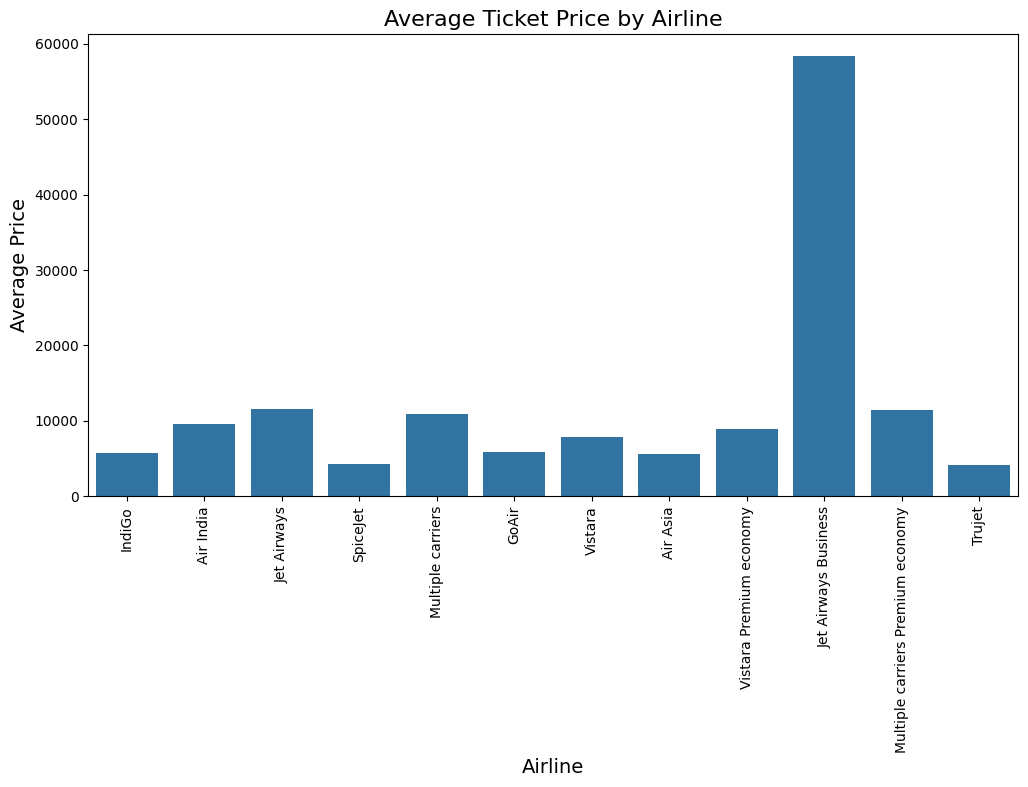

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='Airline', y='Price', estimator='mean', errorbar=None)
plt.title('Average Ticket Price by Airline', fontsize=16)
plt.xlabel('Airline', fontsize=14)
plt.ylabel('Average Price', fontsize=14)
plt.xticks(rotation=90)
plt.show()

This bar chart shows the average ticket price for each airline. This visualization is important because it highlights how ticket prices vary significantly between different airlines. For example, we observe that certain airlines, such as Jet Airways Business, have much higher average ticket prices compared to others. Understanding these variations is crucial, as the airline can be a significant predictor in the regression model. This insight can help us identify the role of airline-specific pricing policies in influencing the target variable and guide the model in capturing these distinctions.



### Visualization 3: Price vs. Total Stops

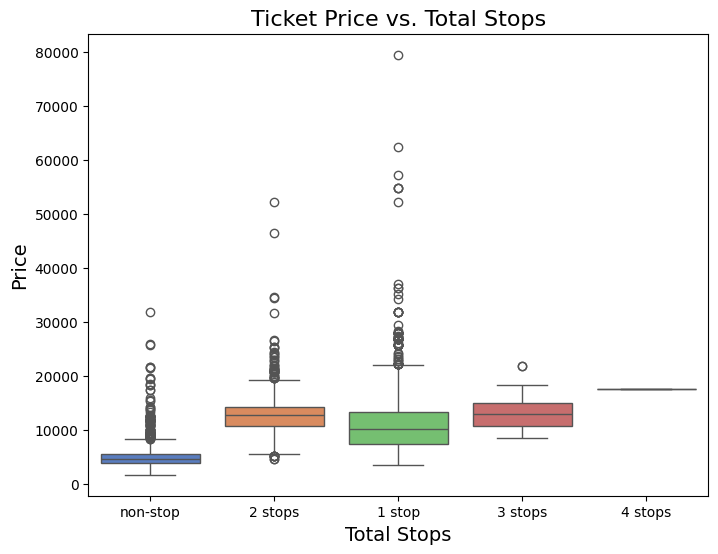

In [ ]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df, x='Total_Stops', y='Price', hue='Total_Stops', palette='muted', dodge=False)
plt.title('Ticket Price vs. Total Stops', fontsize=16)
plt.xlabel('Total Stops', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.show()

This box plot illustrates the relationship between ticket prices and the total number of stops for a flight. This visualization is important as it highlights the trend that flights with fewer stops (e.g., non-stop flights) tend to have lower ticket prices compared to flights with more stops. The plot also shows the spread of prices for each category, including the presence of outliers. This relationship is significant for the regression task because the number of stops can serve as a strong predictor of ticket price, reflecting consumer preferences and the potential added costs of layovers.



### Visualization 4: Flight Duration vs. Price

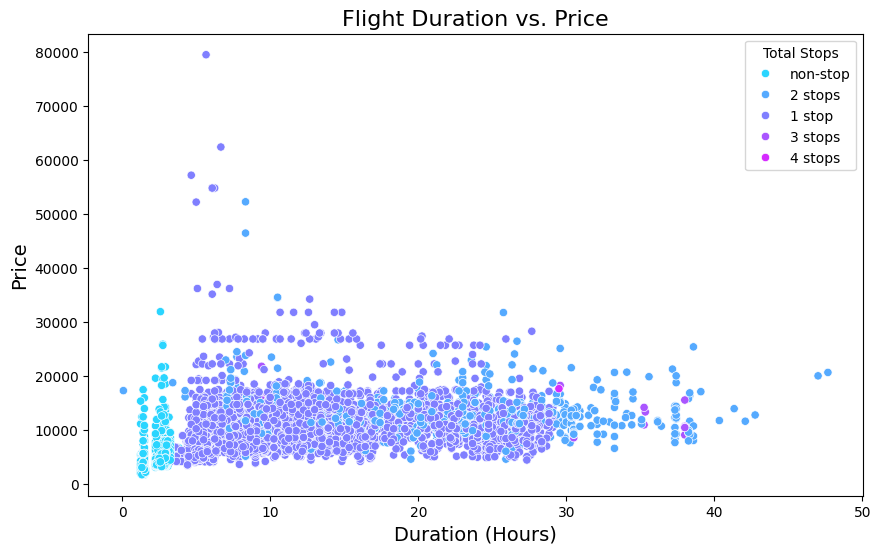

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Duration_Hours', y='Price', hue='Total_Stops', palette='cool')
plt.title('Flight Duration vs. Price', fontsize=16)
plt.xlabel('Duration (Hours)', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(title='Total Stops')
plt.show()

This scatter plot illustrates the relationship between flight duration and ticket price, with a focus on how duration impacts pricing. The trend suggests that longer flights are generally more expensive, which aligns with the intuition that longer flights require more resources. However, the relationship is not perfectly linear, as evident from the significant scatter in the data.

Key observations include diminishing returns for pricing as flight durations become very long and the presence of outliers, such as short flights with unexpectedly high prices or long flights with relatively low prices. Additionally, the color coding indicates the number of stops, showing that non-stop flights dominate shorter durations, while flights with multiple stops tend to have longer durations.

This visualization is crucial for understanding the interplay between flight duration, stops, and pricing, providing valuable insights for modeling and improving prediction accuracy for ticket prices.


### Visualization 5: Average Price by Time of Day

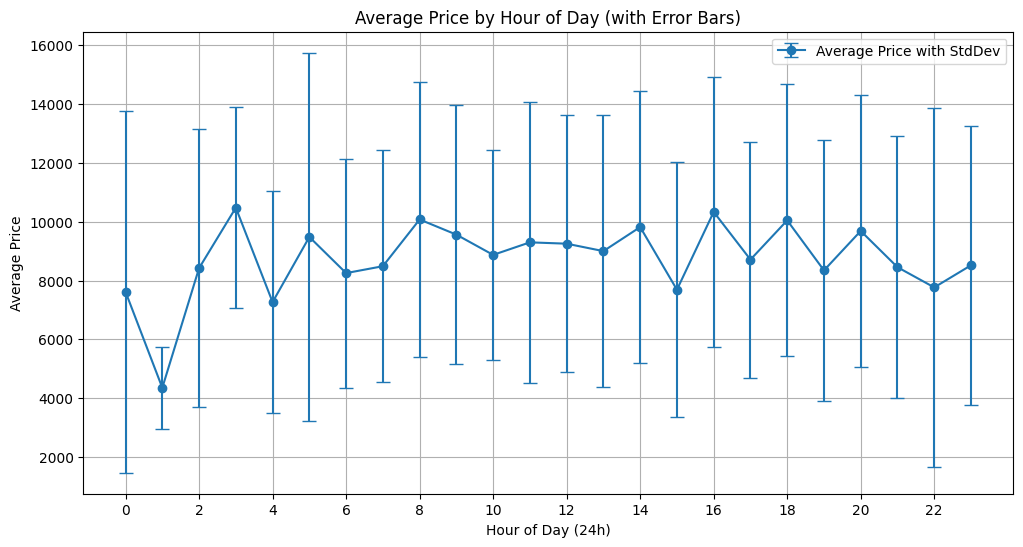

In [ ]:
# Work on a copy of df and extract hour from departure time
df_viz_copy = df.copy()
df_viz_copy['departure_hour'] = df['Dep_Hour'].astype(int)

# Calculate average price and standard deviation by hour
hourly_stats = df_viz_copy.groupby('departure_hour')['Price'].agg(['mean', 'std']).reset_index()
hourly_stats.rename(columns={'mean': 'Average_Price', 'std': 'Price_StdDev'}, inplace=True)

# Plot with error bars
plt.figure(figsize=(12, 6))
plt.errorbar(hourly_stats['departure_hour'], hourly_stats['Average_Price'], yerr=hourly_stats['Price_StdDev'], fmt='-o', capsize=5, label='Average Price with StdDev')
plt.title('Average Price by Hour of Day (with Error Bars)')
plt.xlabel('Hour of Day (24h)')
plt.ylabel('Average Price')
plt.xticks(range(0, 24, 2))
plt.legend()
plt.grid(True)
plt.show()

This plot shows the average flight prices throughout the day, with error bars representing the variability at each hour. It reveals significant fluctuations in prices over the 24-hour period, highlighting both peak and trough pricing times. The error bars indicate substantial variability, suggesting that pricing can vary widely during certain hours. This visualization is important for the project as it helps identify times of the day when flight prices are typically higher or lower, and can be incorporated to improve model performance.

## 4. Basic Model Pipeline

### Data preparation

In [ ]:
df_copy = df.copy()

In [ ]:
# Remove irrelevant columns
df_copy.drop(['Additional_Info'], axis=1, inplace=True)
df_copy.drop(['Route'], axis=1, inplace=True)

In [ ]:
df_copy = pd.get_dummies(df_copy, columns=['Airline', 'Source', 'Destination', 'Total_Stops'], drop_first=True)

In [ ]:
df_copy.head()

,Price,Duration_Hours,Dep_Hour,Arr_Hour,Journey_Day,Journey_Month,Journey_Weekday,Airline_Air India,Airline_GoAir,Airline_IndiGo,...,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi,Total_Stops_2 stops,Total_Stops_3 stops,Total_Stops_4 stops,Total_Stops_non-stop
0,3897,2.833333,22.333333,1.166667,24,3,6,False,False,True,...,False,False,False,False,False,True,False,False,False,True
1,7662,7.416667,5.833333,13.250000,1,5,2,True,False,False,...,False,False,False,False,False,False,True,False,False,False
2,13882,19.000000,9.416667,4.416667,9,6,6,False,False,False,...,False,True,False,False,False,False,True,False,False,False
3,6218,5.416667,18.083333,23.500000,12,5,6,False,False,True,...,False,False,False,False,False,False,False,False,False,False
4,13302,4.750000,16.833333,21.583333,1,3,4,False,False,True,...,False,False,False,False,False,True,False,False,False,False


### Train-test split

In [ ]:
X = df_copy.drop('Price', axis=1)
y = df_copy['Price']

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Train the model

In [ ]:
import xgboost as xgb

In [ ]:
model = xgb.XGBRegressor(random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

### Evaluate the model

In [ ]:
y_pred = model.predict(X_test)

Mean Absolute Error (MAE): 1182.81
Root Mean Squared Error (RMSE): 1793.06
Mean Absolute Percentage Error (MAPE): 13.83%

Sample Errors:
      Actual     Predicted        Error  Percentage_Error
7631   14714  13269.927734  1444.072266          9.814274
7507   11087  12577.113281 -1490.113281         13.440185
2486   12373  12427.209961   -54.209961          0.438131
1422    4544   5366.860840  -822.860840         18.108733
2162   12898  14242.748047 -1344.748047         10.426020


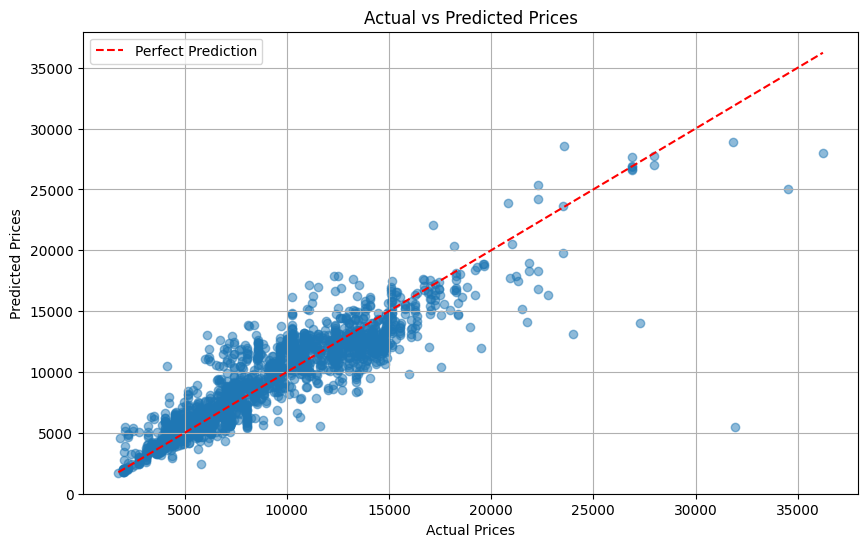

In [ ]:
# Calculate Performance Metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Create error dataframe
error_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
error_df['Error'] = error_df['Actual'] - error_df['Predicted']

error_df['Percentage_Error'] = abs(error_df['Error'] / error_df['Actual']) * 100

# Mean Absolute Percentage Error (MAPE)
mape = np.mean(error_df['Percentage_Error'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Show sample errors
print("\nSample Errors:")
print(error_df[['Actual', 'Predicted', 'Error', 'Percentage_Error']].head())

# Plot Actual vs Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red', label='Perfect Prediction')
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

## 5. Error Analysis

We would like to examine on which items the model performs the worst and on which the best.



In [ ]:
# Add columns to analyze errors
error_df['Overestimation'] = error_df['Predicted'] > error_df['Actual']
error_df['Underestimation'] = error_df['Predicted'] < error_df['Actual']

# Calculate absolute error and sort by absolute error
error_df['Absolute_Error'] = abs(error_df['Error'])
top_10_worst = error_df.nlargest(10, 'Absolute_Error')
top_10_best = error_df.nsmallest(10, 'Absolute_Error')

In [ ]:
# Display top 10 worst predictions and top 10 best predictions
print("Top 10 Worst Predictions:")
display(top_10_worst)
print("\nTop 10 Best Predictions:")
display(top_10_best)

Top 10 Worst Predictions:


,Actual,Predicted,Error,Percentage_Error,Overestimation,Underestimation,Absolute_Error
10052,31945,5461.379395,26483.620605,82.903805,False,True,26483.620605
9193,27282,14010.070312,13271.929688,48.647202,False,True,13271.929688
9974,24017,13159.185547,10857.814453,45.208871,False,True,10857.814453
7617,34503,25035.820312,9467.179688,27.438715,False,True,9467.179688
5719,36235,28025.455078,8209.544922,22.656396,False,True,8209.544922
5162,21730,14108.566406,7621.433594,35.073325,False,True,7621.433594
2628,19508,11929.762695,7578.237305,38.846818,False,True,7578.237305
2525,17531,10377.665039,7153.334961,40.803919,False,True,7153.334961
971,6092,13025.815430,-6933.815430,113.818375,True,False,6933.815430
7120,22794,16332.750000,6461.250000,28.346275,False,True,6461.250000



Top 10 Best Predictions:


,Actual,Predicted,Error,Percentage_Error,Overestimation,Underestimation,Absolute_Error
10593,5158,5158.058594,-0.058594,0.001136,True,False,0.058594
9235,12409,12408.483398,0.516602,0.004163,False,True,0.516602
9390,4804,4802.350586,1.649414,0.034334,False,True,1.649414
4947,3943,3945.031494,-2.031494,0.051522,True,False,2.031494
9902,9345,9347.592773,-2.592773,0.027745,True,False,2.592773
8902,6494,6491.308594,2.691406,0.041445,False,True,2.691406
1570,4409,4412.152344,-3.152344,0.071498,True,False,3.152344
6142,1965,1961.517212,3.482788,0.177241,False,True,3.482788
2510,4423,4419.059082,3.940918,0.089101,False,True,3.940918
6802,5613,5608.375488,4.624512,0.082389,False,True,4.624512


The model performs the worst on items with high actual values and where the predicted values are significantly underestimated.

The model performs best on items with low actual values.

One of the reasons for this could be price outliers. The model might have struggled to correctly predict these outliers because it has learned mostly from more typical values in the training data. High-priced tickets might be influenced by other factors that are harder for the model to capture, such as special offers, additional services, or specific seasonality.

Another reason is complex features. These tickets could be from routes or airlines that involve multiple stops or complex itineraries. For example, tickets with long durations and many stops might have non-linear pricing patterns that are not fully captured by the model.

In addition, the Route and Total Stops features might not be detailed enough to account for all the factors influencing the prices, especially when there are unusual or rare routes.

Model limitations also affect the error. The model might not be capturing the underlying relationship between some features (e.g., the combination of airline, source, destination, and the number of stops) and the price as well as it could. This could happen if certain interactions between features are missed or if the model is too simple to capture more complex patterns.

Moreover, the model relies heavily on the one-hot encoding of categorical features like Airline, Source, and Destination. These encoded features might not always capture the nuanced relationships between them (such as certain routes being more expensive due to demand or specific events).

Now, we would like to check whether the model is predominantly overestimating or underestimating.

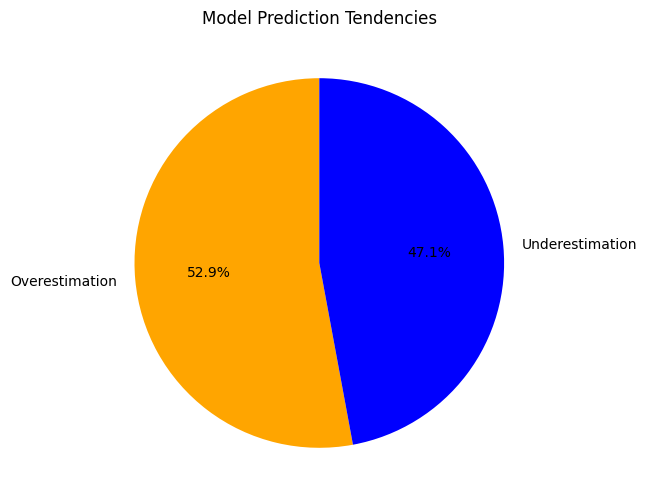

In [ ]:
# Count overestimations and underestimations
overestimation_count = error_df['Overestimation'].sum()
underestimation_count = error_df['Underestimation'].sum()

plt.figure(figsize=(8, 6))
plt.pie([overestimation_count, underestimation_count],
        labels=['Overestimation', 'Underestimation'],
        autopct='%1.1f%%', colors=['orange', 'blue'], startangle=90)
plt.title("Model Prediction Tendencies")
plt.show()

Based on the analysis of the model's prediction tendencies, the model exhibits a slight tendency to overestimate the values. Specifically, the model overestimates 52.9% of the time and underestimates 47.1% of the time.

While the difference is not substantial, this suggests that the model may be more inclined to predict prices that are too high, which could be a result of overfitting to certain high-value examples in the training data.

We will try to determine whether certain features are sabotaging the model.

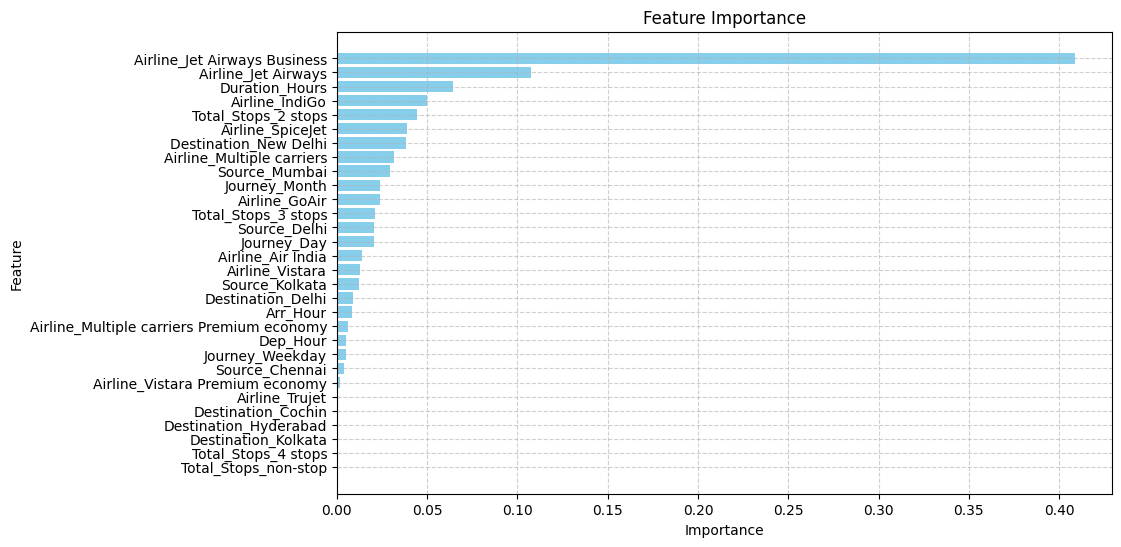


Features with an importance of 0:
Airline_Trujet
Destination_Cochin
Destination_Hyderabad
Destination_Kolkata
Total_Stops_4 stops
Total_Stops_non-stop


In [ ]:
feature_importances = pd.DataFrame({
    'Importance': model.feature_importances_
}, index=X.columns)

# Sort the DataFrame by importance in descending order
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances = feature_importances.reset_index()
feature_importances.columns = ['Feature', 'Importance']

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.gca().invert_yaxis()  # To display the most important feature at the top
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Print features with an importance of 0
zero_importance_features = feature_importances[feature_importances['Importance'] == 0]['Feature']
print("\nFeatures with an importance of 0:")
for feature in zero_importance_features:
    print(feature)

Analyzing feature importance provides valuable insights into the model's behavior and helps identify potential weaknesses. By understanding which features the model relies on most heavily, we can pinpoint areas where errors are more likely to occur. For instance, features like "Airline" or "Duration Hours," which have high importance, suggest that inaccuracies in these features—whether due to noisy data, insufficient representation, or complex relationships—may significantly impact prediction errors.

This insight directs our error analysis toward these key features, helping us identify whether certain values (e.g., very short or very long flight durations) are associated with larger errors. Conversely, features with zero importance, such as "Airline_Trujet," "Destination_Cochin," or "Total_Stops_4 stops," indicate that the model is not utilizing them for predictions. While these features do not directly harm performance, their irrelevance may point to opportunities for model simplification. Removing such features could reduce noise in the dataset, improve interpretability, and streamline the modeling process.

Overall, feature importance not only highlights the strengths of the model but also helps us identify areas for improvement and potential data limitations, providing a roadmap for better understanding and refining model performance.

In [ ]:
# Merge X_test with error_df to include one-hot encoded columns
merge_error_df = error_df.merge(X_test.reset_index(drop=True), left_index=True, right_index=True)

In [ ]:
# Reconstruct the 'Airline', 'Total_Stops', 'Source', and 'Destination' columns and analyze errors accordingly
airline_columns = [col for col in merge_error_df.columns if col.startswith('Airline_')]
merge_error_df['Airline'] = merge_error_df[airline_columns].idxmax(axis=1).str.replace('Airline_', '')
error_by_airline = merge_error_df.groupby('Airline')['Absolute_Error'].mean().sort_values(ascending=False)

total_stops_columns = [col for col in merge_error_df.columns if col.startswith('Total_Stops_')]
merge_error_df['Total_Stops'] = merge_error_df[total_stops_columns].idxmax(axis=1).str.replace('Total_Stops_', '')
error_by_stops = merge_error_df.groupby('Total_Stops')['Absolute_Error'].mean().sort_values(ascending=False)

source_columns = [col for col in merge_error_df.columns if col.startswith('Source_')]
merge_error_df['Source'] = merge_error_df[source_columns].idxmax(axis=1).str.replace('Source_', '')
error_by_source = merge_error_df.groupby('Source')['Absolute_Error'].mean().sort_values(ascending=False)

destination_columns = [col for col in merge_error_df.columns if col.startswith('Destination_')]
merge_error_df['Destination'] = merge_error_df[destination_columns].idxmax(axis=1).str.replace('Destination_', '')
error_by_destination = merge_error_df.groupby('Destination')['Absolute_Error'].mean().sort_values(ascending=False)

# Bin flight duration into categories with explicit labels
duration_bins = [0, 2, 4, 6, 8, merge_error_df['Duration_Hours'].max()]
duration_labels = ['Very Short (0-2 hrs)', 'Short (2-4 hrs)', 'Medium (4-6 hrs)', 'Long (6-8 hrs)', 'Very Long (>8 hrs)']
merge_error_df['Duration_Category'] = pd.cut(
    merge_error_df['Duration_Hours'], bins=duration_bins, labels=duration_labels, right=False
)

# Compute mean absolute error by duration category
error_by_duration = merge_error_df.groupby('Duration_Category', observed=True)['Absolute_Error'].mean()

# Bin hours into time categories
def assign_time_category(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

merge_error_df['Arrival_Time_Category'] = merge_error_df['Arr_Hour'].apply(assign_time_category)
merge_error_df['Departure_Time_Category'] = merge_error_df['Dep_Hour'].apply(assign_time_category)

error_by_arrival_time = merge_error_df.groupby('Arrival_Time_Category')['Absolute_Error'].mean().sort_values(ascending=False)
error_by_departure_time = merge_error_df.groupby('Departure_Time_Category')['Absolute_Error'].mean().sort_values(ascending=False)


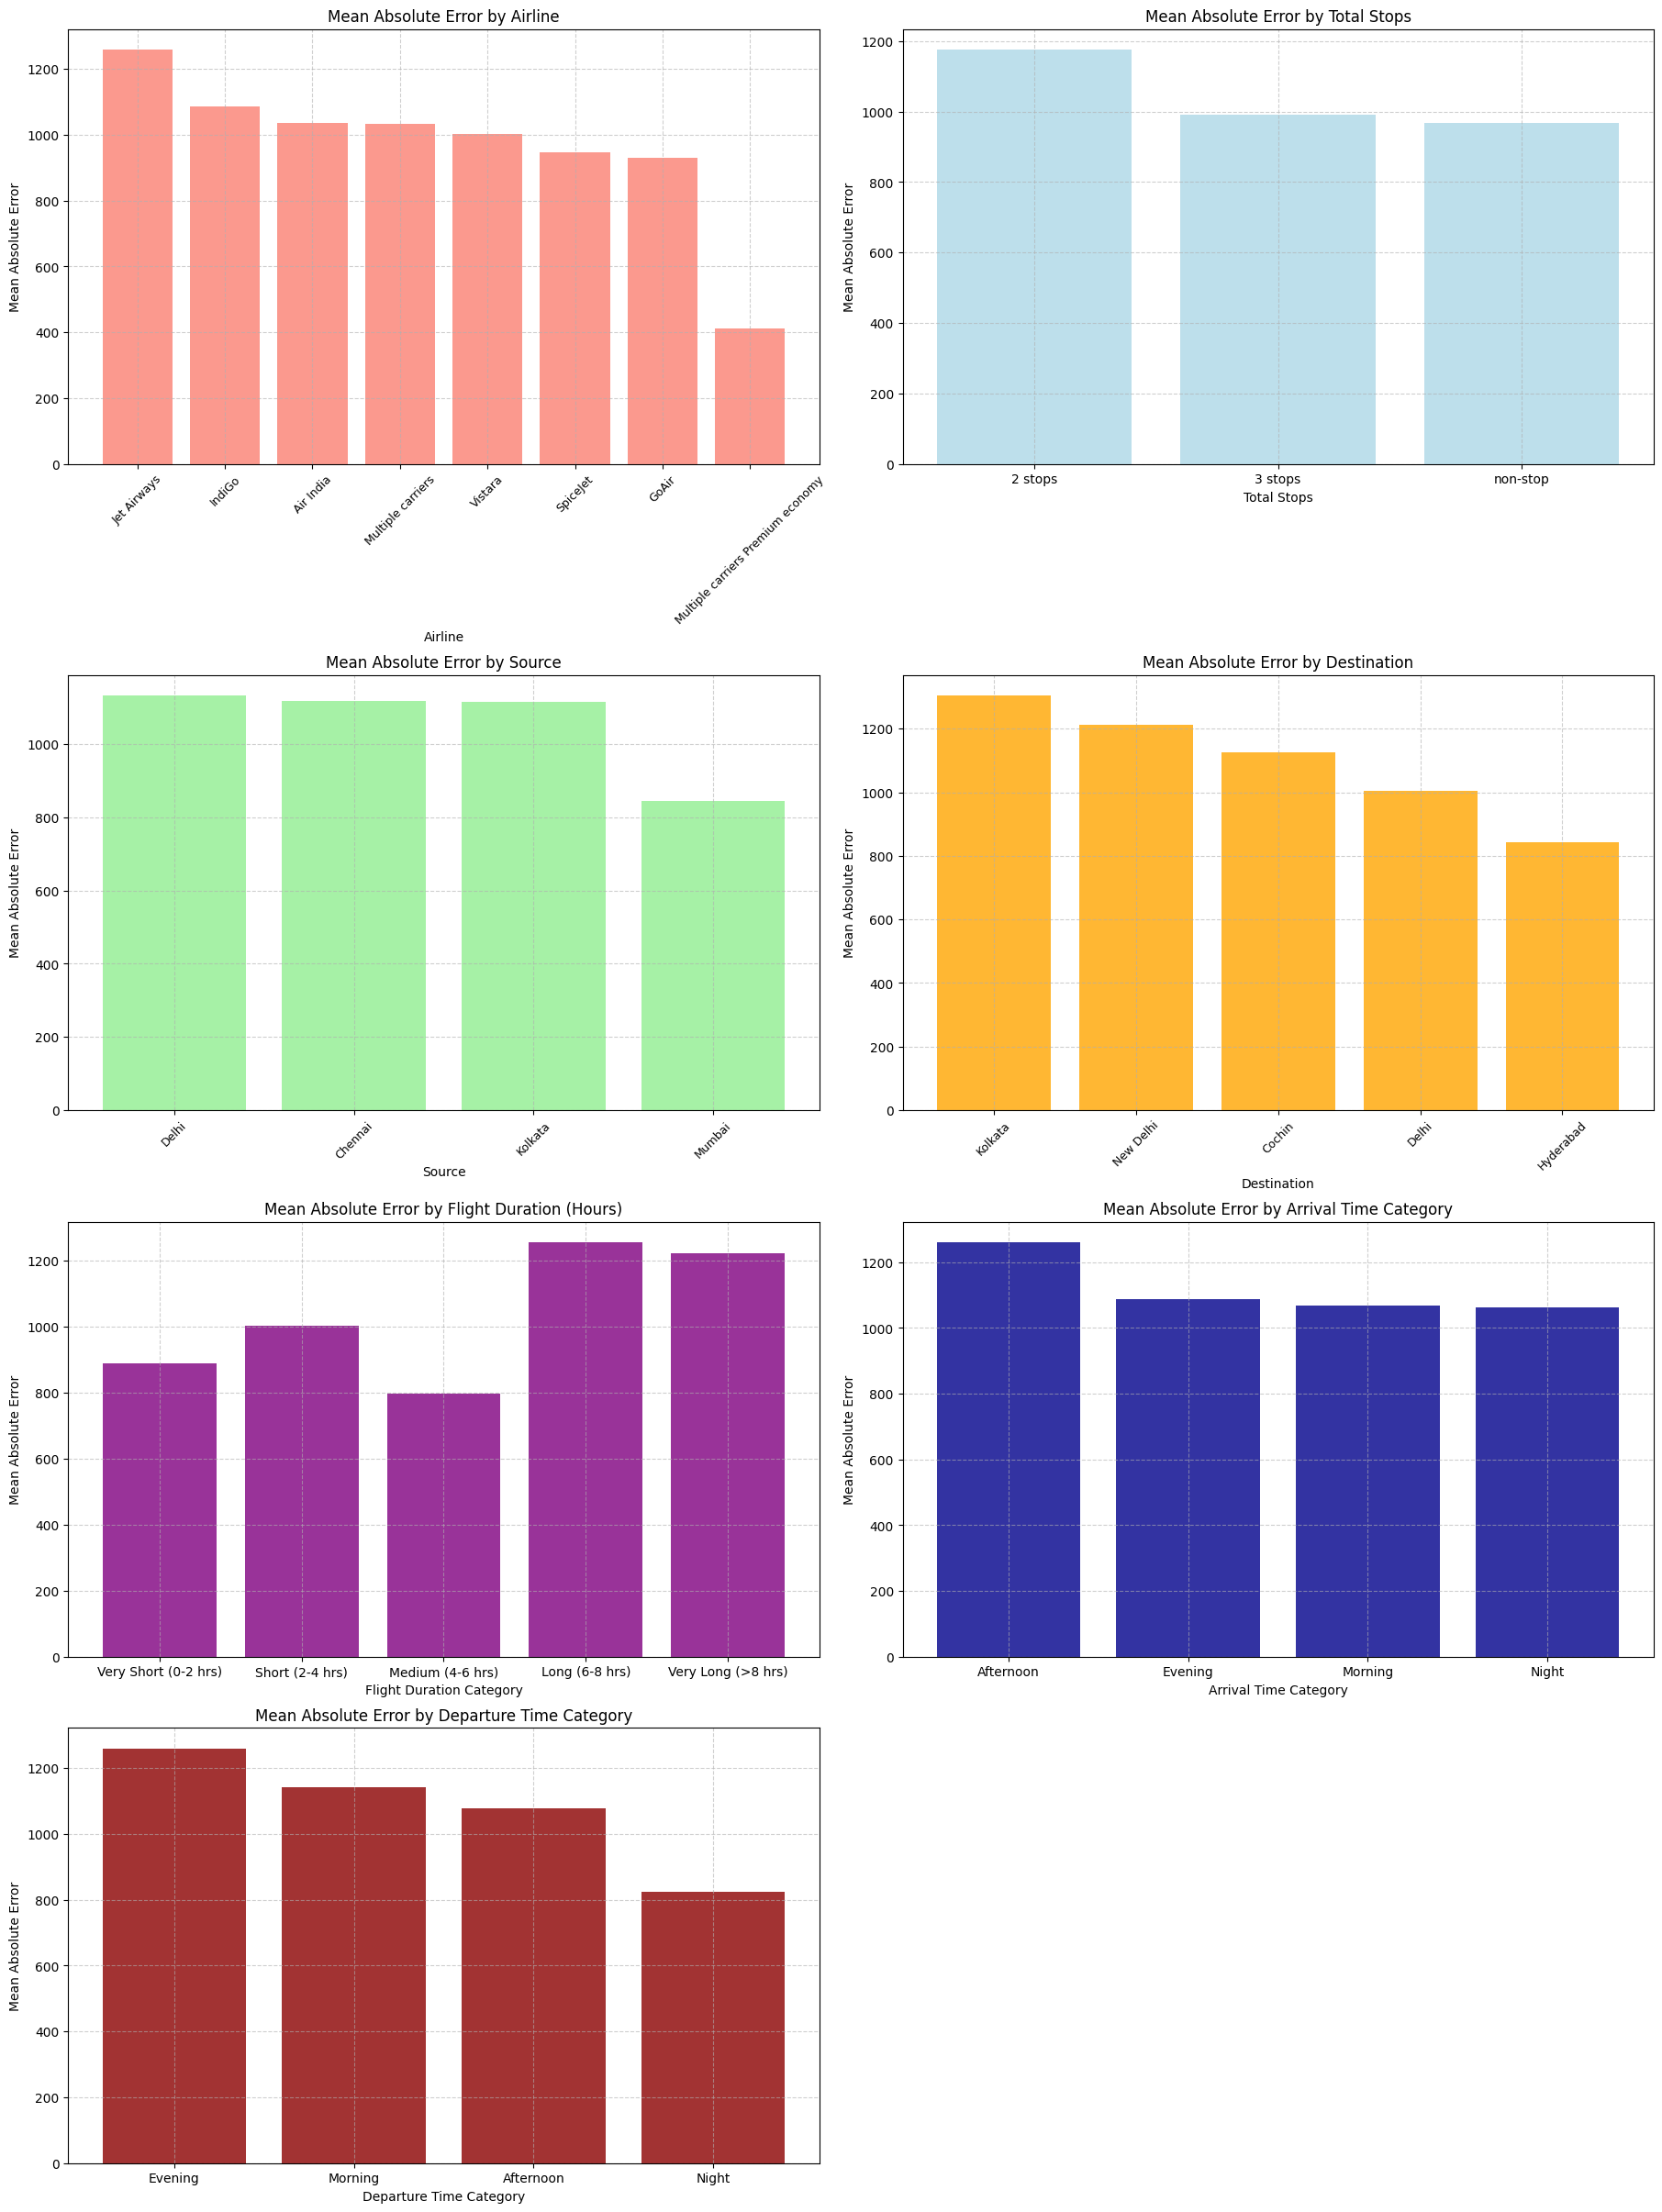

In [ ]:
# Create subplots for all categories and numeric features
fig, axes = plt.subplots(4, 2, figsize=(18, 24), constrained_layout=True)

# By Airline
axes[0, 0].bar(error_by_airline.index, error_by_airline, color='salmon', alpha=0.8)
axes[0, 0].set_title("Mean Absolute Error by Airline")
axes[0, 0].set_xlabel("Airline")
axes[0, 0].set_ylabel("Mean Absolute Error")
axes[0, 0].tick_params(axis='x', rotation=45, labelsize=9)
axes[0, 0].grid(True, linestyle='--', alpha=0.6)

# By Total Stops
axes[0, 1].bar(error_by_stops.index, error_by_stops, color='lightblue', alpha=0.8)
axes[0, 1].set_title("Mean Absolute Error by Total Stops")
axes[0, 1].set_xlabel("Total Stops")
axes[0, 1].set_ylabel("Mean Absolute Error")
axes[0, 1].grid(True, linestyle='--', alpha=0.6)

# By Source
axes[1, 0].bar(error_by_source.index, error_by_source, color='lightgreen', alpha=0.8)
axes[1, 0].set_title("Mean Absolute Error by Source")
axes[1, 0].set_xlabel("Source")
axes[1, 0].set_ylabel("Mean Absolute Error")
axes[1, 0].tick_params(axis='x', rotation=45, labelsize=9)
axes[1, 0].grid(True, linestyle='--', alpha=0.6)

# By Destination
axes[1, 1].bar(error_by_destination.index, error_by_destination, color='orange', alpha=0.8)
axes[1, 1].set_title("Mean Absolute Error by Destination")
axes[1, 1].set_xlabel("Destination")
axes[1, 1].set_ylabel("Mean Absolute Error")
axes[1, 1].tick_params(axis='x', rotation=45, labelsize=9)
axes[1, 1].grid(True, linestyle='--', alpha=0.6)

# By Duration
axes[2, 0].bar(error_by_duration.index.astype(str), error_by_duration, color='purple', alpha=0.8)
axes[2, 0].set_title("Mean Absolute Error by Flight Duration (Hours)")
axes[2, 0].set_xlabel("Flight Duration Category")
axes[2, 0].set_ylabel("Mean Absolute Error")
axes[2, 0].grid(True, linestyle='--', alpha=0.6)

# By Arrival Time
axes[2, 1].bar(error_by_arrival_time.index, error_by_arrival_time, color='darkblue', alpha=0.8)
axes[2, 1].set_title("Mean Absolute Error by Arrival Time Category")
axes[2, 1].set_xlabel("Arrival Time Category")
axes[2, 1].set_ylabel("Mean Absolute Error")
axes[2, 1].grid(True, linestyle='--', alpha=0.6)

# By Departure Time
axes[3, 0].bar(error_by_departure_time.index, error_by_departure_time, color='darkred', alpha=0.8)
axes[3, 0].set_title("Mean Absolute Error by Departure Time Category")
axes[3, 0].set_xlabel("Departure Time Category")
axes[3, 0].set_ylabel("Mean Absolute Error")
axes[3, 0].grid(True, linestyle='--', alpha=0.6)

# Hide empty subplot
axes[3, 1].axis('off')

# Show all plots
plt.show()

The error analysis reveals several patterns in the model's weaknesses. First, the model performs worse for airlines like Jet Airways and IndiGo, which have a wider range of prices, while it shows better performance for smaller airlines like GoAir. This indicates that the high variability in pricing for major airlines may introduce complexity that the model struggles to handle.  

Additionally, flights with multiple stops, such as "2 stops" and "3 stops," result in higher errors compared to "non-stop" flights. This may be due to the increased variability in pricing for flights with more stops, which could be influenced by factors like layover durations and connections.

In terms of flight duration, the model performs better for very short flights (0-2 hours), short flights (2-4 hours) and medium (4-6 hours), while errors increase for long flights (6-8 hours). This could be due to the greater variation in pricing strategies for longer flights, such as those involving different aircraft types or service levels.  

Finally, when analyzing time categories, flights during the evening show higher errors compared to other times of the day. This may reflect unique pricing strategies applied during peak travel hours. Across these categories, it appears that features related to pricing variability and demand contribute significantly to the model's errors, highlighting areas where improvements could focus on better handling these complexities.

Now we will try to find common lines between the erroneous samples.

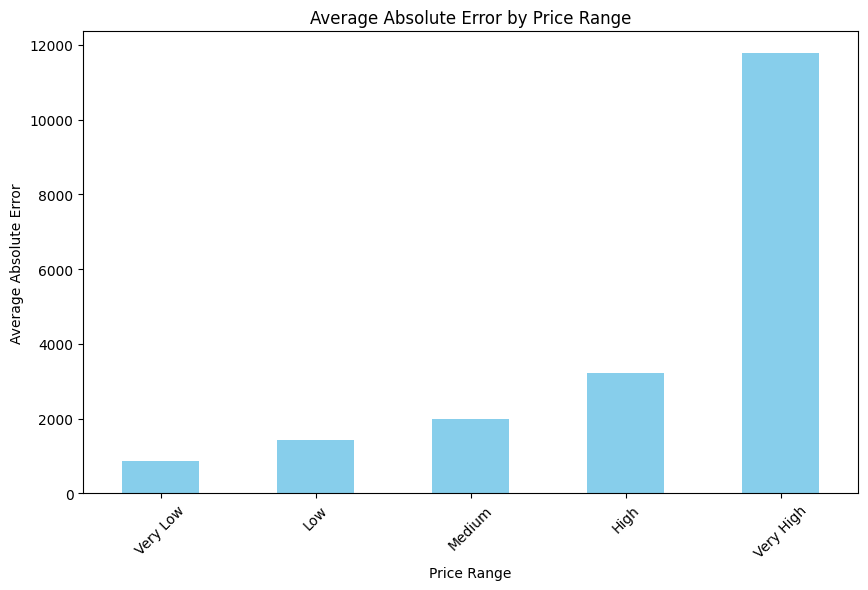

In [ ]:
# Analyze errors by price range
error_df['Price_Range'] = pd.cut(error_df['Actual'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
avg_error_by_price_range = error_df.groupby('Price_Range', observed=False)['Absolute_Error'].mean()

# Visualize average error by price range
plt.figure(figsize=(10, 6))
avg_error_by_price_range.plot(kind='bar', color='skyblue')
plt.title("Average Absolute Error by Price Range")
plt.xlabel("Price Range")
plt.ylabel("Average Absolute Error")
plt.xticks(rotation=45)
plt.show()

The graph shows the average absolute error (MAE) across different price ranges, highlighting how the model's performance varies with the target price. It is evident that the "Very High" price range has significantly larger errors, indicating that the model struggles to accurately predict flights with very high prices.

This analysis is important for the project because it identifies weaknesses in the model's predictions for specific price ranges. While it is intuitive that absolute errors may increase with higher values, the graph provides evidence that the "Very High" price range is particularly problematic. This suggests that there may be underlying factors contributing to the difficulty in predicting these values, such as:
- Unique characteristics of high-priced flights (e.g., luxury flights or last-minute purchases).
- The presence of outliers or non-linear relationships that the model fails to capture effectively.

## Sources
- https://www.geeksforgeeks.org/ml-one-hot-encoding/
- https://www.kaggle.com/code/amarjitsingh1/flight-price-predection
- ChatGPT